In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pickle, os, math, glob, re
import multiprocessing as mp
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn import gaussian_process
from sklearn import preprocessing
from sklearn import neural_network

from scipy import stats
import gzip

In [3]:
def plot_errors(y1, y2):
    plt.figure()
    plt.scatter(y1, y2)
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.title('Prediction vs. True values')
    plt.figure()
    plt.hist(y1-y2, 50, facecolor='red')
    plt.title('The prediction error distribution')

In [4]:
class LeafNode:
    
    def __init__(self):
        self.X, self.y, self.pairs = [], [], []
        
    def append(self, X, y, pair):
        #print('id(self)', id(self), 'append X.shape', X.shape, 'y', y)
        self.X.append(X.ravel())
        self.y.append(y)
        self.pairs.append(pair)
        #print('len(self.X):', len(self.X), 'len(y):', len(self.y))
    
    def __str__(self):
        return 'leaf has ' + str(len(self.y)) + ' samples'

    def lreg(self):
        linreg = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
        #print('fit linear regression')
        #print('len(X):', len(self.X), 'y:', len(self.y))
        #print('X.shape:', np.array(self.X).shape, 'y.shape:', np.array(self.y).shape)
        linreg.fit(np.array(self.X), np.array(self.y))
        return linreg

In [5]:
class LWR(object):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X):
        pass

In [6]:
class LinearRegETR(ExtraTreesRegressor):
    
    def __init__(self, n_estimators=10, n_jobs=1):
        super(LinearRegETR, self).__init__(n_estimators=n_estimators, n_jobs=n_jobs)
    
    def fit_leaf_model(self, X, y, pairs):

        # dictionary for each tree in the ensemble
        self.ensemble_leaf_data = [{}] * self.n_estimators
        #print('number of estimators:', self.n_estimators)
        
        # for each sample
        #print('shape of the training data X:', X.shape, 'y:', y.shape)
        k=0
        for x, y_value, pair in zip(X, y, pairs):
            k = k + 1
            # as per np request :)
            x = x.reshape(1,-1)
            
            # get a list of leafs that each point lands in
            indices = self.apply(x)[0]
        
            # put them in the dictionary
            #print('update leaf models with a new sample')
            for tnum, lind in enumerate(indices):
                lnode = self.ensemble_leaf_data[tnum].get(lind, LeafNode())
                lnode.append(x, y_value, pair)
                self.ensemble_leaf_data[tnum][lind] = lnode
                
        #print('processed samples:', k)
        #for tree in self.ensemble_leaf_data:
        #    for leafs in tree:
        #        for key, value in tree.items():
        #            print(key, ':', value)

    def leaf_model_predict(self, X):
        result = []
        pairs = []
        for x in X:
            x = x.reshape(1, -1)
            leaf_indices = self.apply(x)[0]
            y_pred = [None]*self.n_estimators
            for tnum, lind in enumerate(leaf_indices):
                leaf_node = self.ensemble_leaf_data[tnum].get(lind)
                pairs.append(leaf_node.pairs)
                lr_pred = leaf_node.lreg().predict(x)
                y_mean, y_std = np.mean(leaf_node.y), np.std(leaf_node.y)
                
                # if LR predicts a value to far away, use the mean as the predictor
                if abs(lr_pred - y_mean)/y_std > 3.0:
                    y_pred[tnum] = y_mean
                else:
                    y_pred[tnum] = lr_pred
                    
            result.append(np.mean(y_pred))
        return (np.array(result), pairs)

    def fit(self, X, y, pairs):
        model = super(LinearRegETR, self).fit(X, y)
        self.fit_leaf_model(X, y, pairs)
        return model
    
    def predict(self, X):
        return self.leaf_model_predict(X)

In [7]:
def fit_and_save(dataset_label, models):
    label = dataset_label
    
    # load the training and the validation data
    train = pickle.load(gzip.open('data/datasets/train_%s.pklz' % label, 'rb'))
    X_train, y_train, pairs_train = train['X'], train['y'], train['pairs']

    # compute the mean and the std
    scaler = preprocessing.StandardScaler().fit(X_train)
    # subtract the mean and divide by the std
    X_train = scaler.transform(X_train)
    
    stats_res = stats.describe(y_train)
    plt.figure()
    n, bins, patches = plt.hist(y_train, 50, normed=1, facecolor='green', alpha=0.75)
    plt.grid(True)
    plt.title('Target (train) distribution: %s $\mu=%0.2g,\sigma=%0.2g$' % (label, stats_res.mean, math.sqrt(stats_res.variance)))

    valid = pickle.load(gzip.open('data/datasets/valid_%s.pklz' % label, 'rb'))
    X_valid, y_valid, pairs_valid = scaler.transform(valid['X']), valid['y'], valid['pairs']

    pairs, validation_errors = [], []
    for tag, clf, need_pairs in models:
        print('train the model:', tag, 'for the dataset:', label)
        start = timer()
        if need_pairs:
            clf.fit(X_train, y_train, pairs_train)
        else:
            clf.fit(X_train, y_train)

        end = timer()
        print('elapsed wall time:', end-start)
    
        # compute the predictions the validation data
        if need_pairs:
            y_pred, pairs = clf.predict(X_valid)
        else:
            y_pred = clf.predict(X_valid)

        rmse = math.sqrt(mean_squared_error(y_pred, y_valid))
        print("RMSE: %.2f" % rmse)

        plot_errors(y_pred, y_valid)

        validation_errors.append(rmse)
        
        try:
            with gzip.open(os.path.join('data', 'models', '%s_%s.pklz' % (tag, label)), 'wb') as fid:
                pickle.dump(clf, fid)
        except:
            pass

        plt.show()
        
    return validation_errors


['1_6_3_300']


<IPython.core.display.Javascript object>


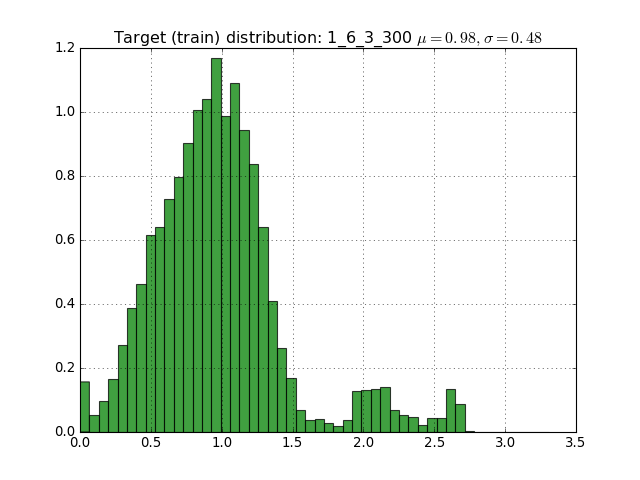

train the model: ETR for the dataset: 1_6_3_300
elapsed wall time: 207.3437686420002
RMSE: 0.20


<IPython.core.display.Javascript object>


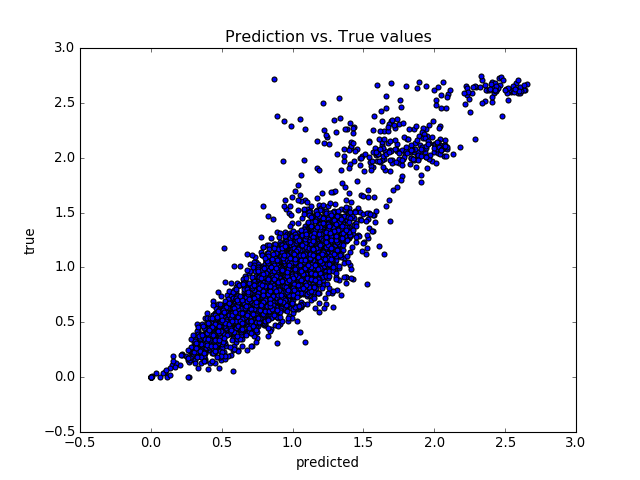

<IPython.core.display.Javascript object>


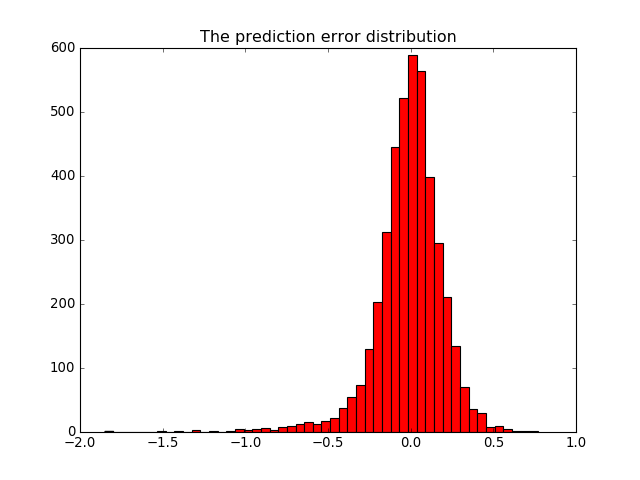

In [8]:
labels = []


files = glob.glob('data/datasets/data_*.pklz')

# p = re.compile(r'.*\/data_(.*)\.pklz')
# p = re.compile(r'.*data_([12]_6_4_300)\.pklz')
p = re.compile(r'.*data_(1_6_3_300)\.pklz')
for file in files:
    try:
        labels.append(p.match(file).group(1))
    except AttributeError:
        pass
print(labels)
#models = [('LRETR', LinearRegETR(), True),
#          ('ETR', ExtraTreesRegressor(), False)]
models = [('ETR', ExtraTreesRegressor(), False)]
errors = defaultdict(list)
for label in labels:
    validation_errors = fit_and_save(label, models)
    for i, model in enumerate(models):
        errors[model[0]].append(validation_errors[i])

<IPython.core.display.Javascript object>


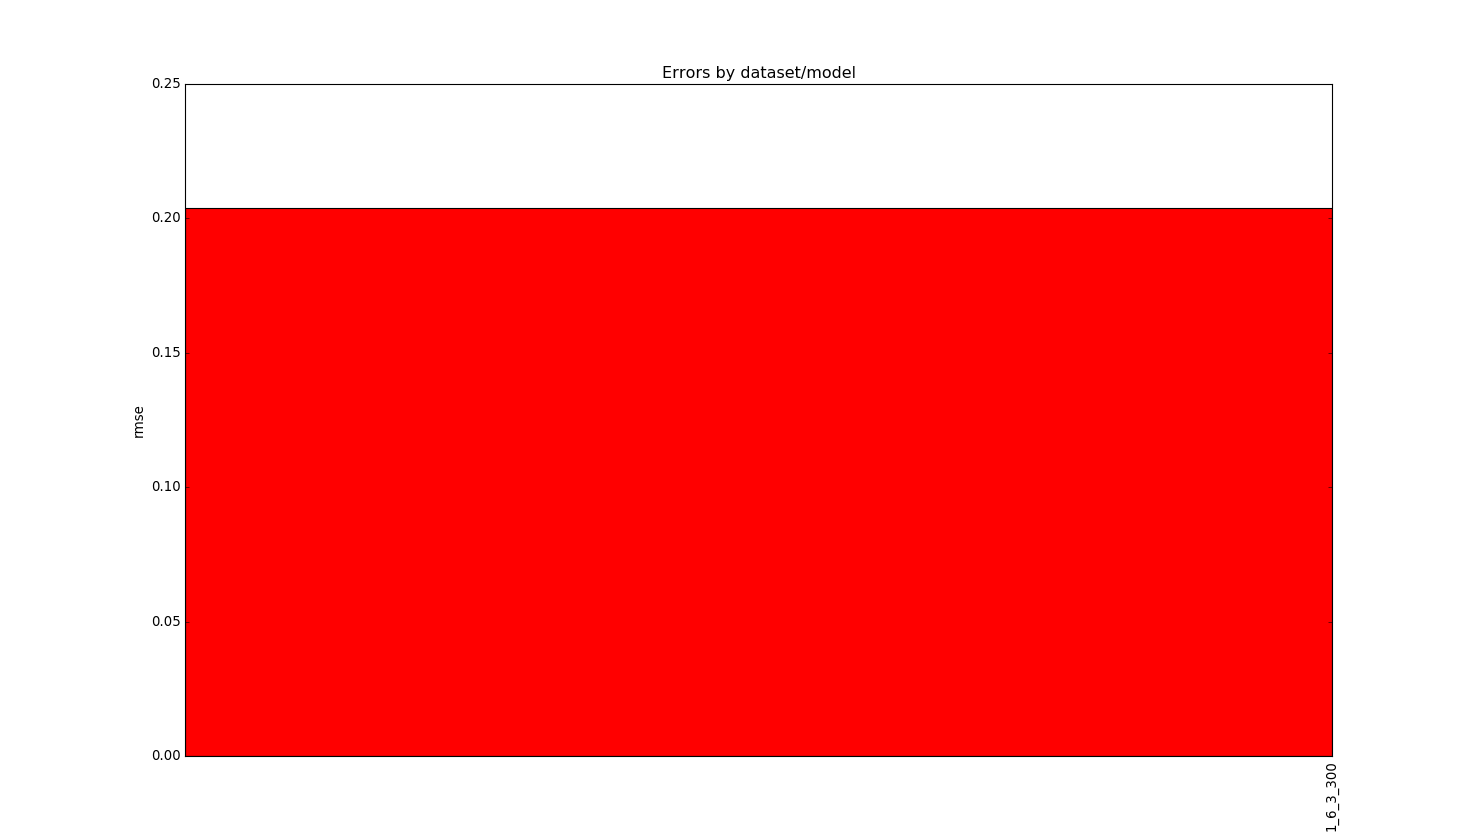

In [9]:
N = len(labels)
ind = np.arange(N)  # the x locations for the groups
width = 0.35        # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)

rects1 = ax.bar(ind, errors[models[0][0]], width, color='r')
#rects2 = ax.bar(ind + width, errors[models[1][0]], width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('rmse')
ax.set_title('Errors by dataset/model')
ax.set_xticks(ind + width)
ax.set_xticklabels(labels, rotation='vertical')
#ax.legend((rects1[0], rects2[0]), (models[0][0], models[1][0]))
plt.show()

In [10]:
print(models)
min_ind = np.argmin(errors[models[0][0]])
print('min ind:', labels[min_ind], errors[models[0][0]][min_ind])

[('ETR', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False), False)]
min ind: 1_6_3_300 0.20400574190473242
